In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from geopy.distance import geodesic
from matplotlib import gridspec
import cmaps

In [2]:
# Load IBTrACS data
data = pd.read_csv('Data_TC/Proc/JTWC_Hurdat_1999_2018.csv')

data['ISO_TIME'] = pd.to_datetime(data['ISO_TIME'])
data = data[(data['ISO_TIME'] >= '1999-03-01') & (data['ISO_TIME'] <= '2018-12-31')]
data = data[(data['USA_LAT'] >= -40) & (data['USA_LAT'] <= 40) &
            (data['USA_WIND'] > 34)]
data['USA_LON'] = np.where(data['USA_LON'] < 0, data['USA_LON'] + 360, data['USA_LON'])


def calculate_motion_vectors(df):
    df = df.sort_values(by='ISO_TIME').reset_index(drop=True)
    
    vx, vy = [np.nan], [np.nan]  
    for i in range(1, len(df)):
        prev_point = (df['USA_LAT'].iloc[i-1], df['USA_LON'].iloc[i-1])
        curr_point = (df['USA_LAT'].iloc[i], df['USA_LON'].iloc[i])

        distance_m = geodesic(prev_point, curr_point).meters
        
        delta_lon = np.radians(df['USA_LON'].iloc[i] - df['USA_LON'].iloc[i-1])
        lat1 = np.radians(df['USA_LAT'].iloc[i-1])
        lat2 = np.radians(df['USA_LAT'].iloc[i])
        
        x = np.sin(delta_lon) * np.cos(lat2)
        y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon))
        bearing = np.arctan2(x, y)

        time_diff = 21600  # seconds
        vx.append(distance_m * np.sin(bearing) / time_diff)
        vy.append(distance_m * np.cos(bearing) / time_diff) 

    df['vx'] = vx
    df['vy'] = vy

    return df

data = data.groupby('SID', group_keys=False).apply(calculate_motion_vectors).reset_index(drop=True)
data = data.dropna(subset=['vx', 'vy'])

data['lat_bin'] = (data['USA_LAT'] // 5) * 5
data['lon_bin'] = (data['USA_LON'] // 5) * 5

data = data[~((data['USA_LON'] > 1) & (data['USA_LON'] < 10))]
grid_grouped = data.groupby(['lat_bin', 'lon_bin']).agg(
    avg_vx=('vx', 'mean'), 
    avg_vy=('vy', 'mean'),
    num_years=('ISO_TIME', lambda x: x.dt.year.nunique()) 
).reset_index()

grid_grouped = grid_grouped[grid_grouped['num_years'] >= 4]
grid_grouped['speed'] = np.sqrt(grid_grouped['avg_vx']**2 + grid_grouped['avg_vy']**2)

grid_size = 5
lon_bins = np.arange(0, 360 + grid_size, grid_size) 
lat_bins = np.arange(-40, 40 + grid_size, grid_size)

# Create a speed grid for plotting with shape (25, 73)
speed_grid_obs = np.full((len(lat_bins), len(lon_bins)), np.nan) 

for i, row in grid_grouped.iterrows():
    lon_idx = np.searchsorted(lon_bins, row['lon_bin'], side='right') - 1
    lat_idx = np.searchsorted(lat_bins, row['lat_bin'], side='right') - 1

    if 0 <= lon_idx < speed_grid_obs.shape[1] and 0 <= lat_idx < speed_grid_obs.shape[0]:
        speed_grid_obs[lat_idx, lon_idx] = row['speed']

In [3]:
# Define the list of file paths for IAP-CAS
file_paths = [
    'Data_TC/Proc/ID_merged_all_track_week1_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week2_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week3_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week4_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week5_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week6_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week7_lag0_1999_2018_global_jan_dec.csv'
]

polygon_coords = np.array([[300, 0], [300, -40], [355, -40], [355, 0]])
polygon_path = Path(polygon_coords)

def is_within_polygon(lon, lat):
    return polygon_path.contains_point((lon, lat))

sid_prefixes = ('11', '12', '13', '14', '21', '22', '23', '24', '31', '33', '34', '41', '42', '43', '44')

def calculate_motion_vectors(df1):
    df1 = df1.sort_values(by='ISO_TIME').reset_index(drop=True)
    
    vxx, vyy = [np.nan], [np.nan]
    for i in range(1, len(df1)):
        prev_point = (df1['lat_ni_f'].iloc[i-1], df1['lon_ni_f'].iloc[i-1])
        curr_point = (df1['lat_ni_f'].iloc[i], df1['lon_ni_f'].iloc[i])

        distance_m = geodesic(prev_point, curr_point).meters
        delta_lon = np.radians(df1['lon_ni_f'].iloc[i] - df1['lon_ni_f'].iloc[i-1])
        lat1, lat2 = np.radians(df1['lat_ni_f'].iloc[i-1]), np.radians(df1['lat_ni_f'].iloc[i])

        xx = np.sin(delta_lon) * np.cos(lat2)
        yy = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon))
        bearing = np.arctan2(xx, yy)

        time_diff = 21600  # 6 hours in seconds

        vxx.append(distance_m * np.sin(bearing) / time_diff)
        vyy.append(distance_m * np.cos(bearing) / time_diff)

    df1['vxx'], df1['vyy'] = vxx, vyy
    return df1



week_results = {}
for idx, file_path in enumerate(file_paths):
    data1 = pd.read_csv(file_path)
    data1['ISO_TIME'] = pd.to_datetime(data1[['year', 'month', 'day', 'hour']])
    data1 = data1[(data1['ISO_TIME'].dt.year >= 1999) & (data1['ISO_TIME'].dt.year <= 2018)]
    data1 = data1[(data1['lat_ni_f'] >= -60) & (data1['lat_ni_f'] <= 60) & 
                (data1['lon_ni_f'] >= 0) & (data1['lon_ni_f'] <= 360) & 
                (data1['wind'] > 1)]
    data1 = data1[~data1.apply(lambda row: is_within_polygon(row['lon_ni_f'], row['lat_ni_f']), axis=1)]
    all_grid_data1 = []
    for prefix in sid_prefixes:
        data_prefix1 = data1[data1['SID'].astype(str).str.startswith(prefix)]
        data_prefix1 = data_prefix1.groupby('SID', group_keys=False).apply(calculate_motion_vectors).reset_index(drop=True)
        data_prefix1 = data_prefix1.dropna(subset=['vxx', 'vyy'])
        data_prefix1['lat_bin1'] = (data_prefix1['lat_ni_f'] // 5) * 5
        data_prefix1['lon_bin1'] = (data_prefix1['lon_ni_f'] // 5) * 5
        data_filtered1 = data_prefix1.groupby(['lat_bin1', 'lon_bin1']).filter(lambda x: x['ISO_TIME'].dt.year.nunique() >= 4)
        grid_grouped1 = data_filtered1.groupby(['lat_bin1', 'lon_bin1']).agg(
            avg_vxx=('vxx', 'mean'),
            avg_vyy=('vyy', 'mean'),
            num_years=('ISO_TIME', lambda x: x.dt.year.nunique())
        ).reset_index()
        
        grid_grouped1['speed'] = np.sqrt(grid_grouped1['avg_vxx']**2 + grid_grouped1['avg_vyy']**2)
        all_grid_data1.append(grid_grouped1)
        
    combined_grid_data1 = pd.concat(all_grid_data1, ignore_index=True)
    week_results[f'week{idx+1}_all'] = combined_grid_data1


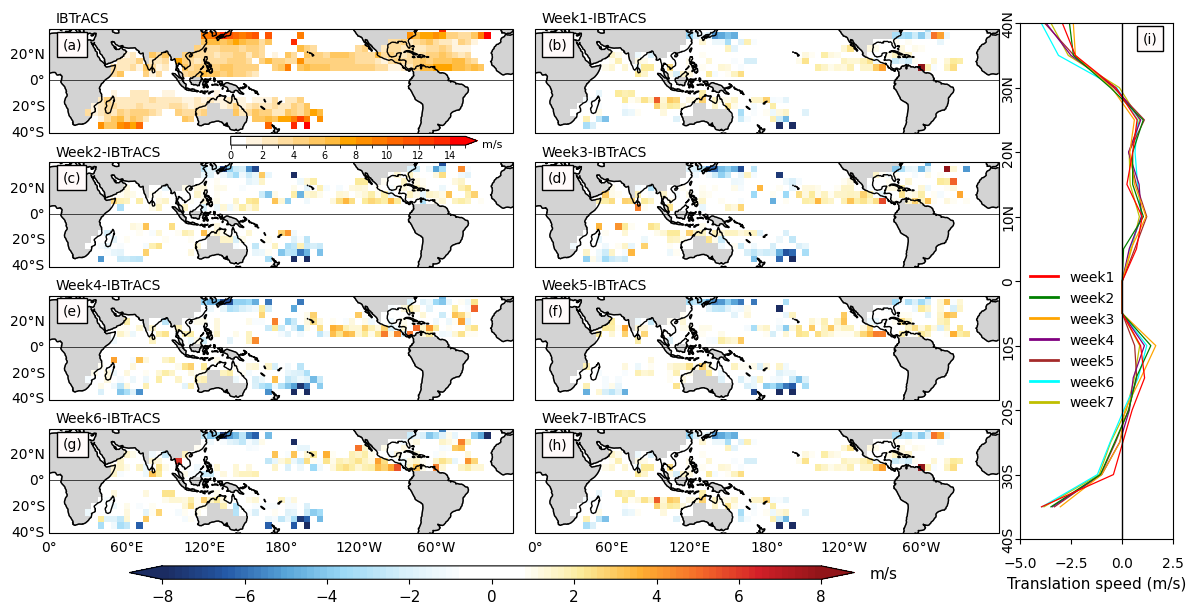

In [8]:

import warnings
warnings.filterwarnings('ignore')


fig = plt.figure(figsize=(14.5, 6.7))
gs = gridspec.GridSpec(4, 3, figure=fig, width_ratios=[1, 1, 0.33], height_ratios=[1, 1, 1, 1])

# Create the subplots for the first two columns across 4 rows for spatial data
axs = [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree(central_longitude=180)) for row in range(4) for col in range(2)]
#ax.set_extent([-180, 180, -40, 40], crs=ccrs.PlateCarree())

ax1 = axs[0]
ax1.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE)

gl1 = ax1.gridlines(draw_labels=True, linewidth=0.001)
gl1.top_labels = False
gl1.right_labels = False
#gl.xlocator = plt.FixedLocator(np.arange(0, 361, 30))  
gl1.xlabels_bottom = False  
gl1.ylocator = plt.FixedLocator(np.arange(-40, 41, 20)) 
gl1.ylabels_left = True  

colors = ["white", "orange", "red",]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("white_yellow_red", colors, N=17) 
norm = mcolors.BoundaryNorm(boundaries=np.linspace(0, 15, 16), ncolors=17)

shading1 = ax1.pcolormesh(lon_bins, lat_bins, speed_grid_obs, cmap=custom_cmap, norm=norm, transform=ccrs.PlateCarree())
ax1.set_extent([-180, 180, -41, 40], crs=ccrs.PlateCarree())

ax2 = axs[1]
ax2.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax2.add_feature(cfeature.COASTLINE)

# Add gridlines
gl2 = ax2.gridlines(draw_labels=True, linewidth=0.001)
gl2.top_labels = False
gl2.right_labels = False
gl2.xlabels_bottom = False 
gl2.ylocator = plt.FixedLocator(np.arange(-40, 41, 20)) 
gl2.ylabels_left = False


cmap = plt.get_cmap('BlueWhiteOrangeRed', 100) 
colors = cmap(np.linspace(0, 1, 100))  
custom_cmapp = mcolors.ListedColormap(colors)  
norm = mcolors.Normalize(vmin=-8, vmax=8)

#.......................................................................................................................................................
week1_all = week_results.get('week1_all', None)
week2_all = week_results.get('week2_all', None)
week3_all = week_results.get('week3_all', None)
week4_all = week_results.get('week4_all', None)
week5_all = week_results.get('week5_all', None)
week6_all = week_results.get('week6_all', None)
week7_all = week_results.get('week7_all', None)


for week_num in range(1, 8):
    week_data = globals()[f'week{week_num}_all']  
    
    speed_grid = np.full((len(lat_bins), len(lon_bins)), np.nan)
    for i, row in week_data.iterrows():
        lon_idx = np.where(lon_bins == row['lon_bin1'])[0]
        lat_idx = np.where(lat_bins == row['lat_bin1'])[0]
        if lon_idx.size > 0 and lat_idx.size > 0:
            speed_grid[lat_idx[0], lon_idx[0]] = row['speed']
    globals()[f'speed_grid{week_num}'] = speed_grid


week1_bias=speed_grid1-speed_grid_obs
week2_bias=speed_grid2-speed_grid_obs
week3_bias=speed_grid3-speed_grid_obs
week4_bias=speed_grid4-speed_grid_obs
week5_bias=speed_grid5-speed_grid_obs
week6_bias=speed_grid6-speed_grid_obs
week7_bias=speed_grid7-speed_grid_obs


shading = ax2.pcolormesh(lon_bins, lat_bins, week1_bias, cmap=custom_cmapp, norm=norm, transform=ccrs.PlateCarree()) #cmaps.BlueWhiteOrangeRed

ax2.set_extent([-180, 180, -41, 40], crs=ccrs.PlateCarree())

ax3 = axs[2]
ax3.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax3.add_feature(cfeature.COASTLINE)

# Add gridlines
gl3 = ax3.gridlines(draw_labels=True, linewidth=0.001)
gl3.top_labels = False
gl3.right_labels = False
#gl.xlocator = plt.FixedLocator(np.arange(0, 361, 30))  
gl3.xlabels_bottom = False  # Show x labels at the bottom
gl3.ylocator = plt.FixedLocator(np.arange(-40, 41, 20))  
gl3.ylabels_left = True  # Show y labels on the left


shading = ax3.pcolormesh(lon_bins, lat_bins, week2_bias, cmap=custom_cmapp, norm=norm, transform=ccrs.PlateCarree())
ax3.set_extent([-180, 180, -41, 40], crs=ccrs.PlateCarree())


ax4 = axs[3]
ax4.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax4.add_feature(cfeature.COASTLINE)

# Add gridlines
gl4 = ax4.gridlines(draw_labels=True, linewidth=0.001)
gl4.top_labels = False
gl4.right_labels = False
gl4.xlabels_bottom = False  # Show x labels at the bottom
gl4.ylocator = plt.FixedLocator(np.arange(-40, 41, 20))  
gl4.ylabels_left = False  
shading = ax4.pcolormesh(lon_bins, lat_bins, week3_bias, cmap=custom_cmapp, norm=norm, transform=ccrs.PlateCarree())
ax4.set_extent([-180, 180, -41, 40], crs=ccrs.PlateCarree())

ax5 = axs[4]
ax5.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax5.add_feature(cfeature.COASTLINE)
gl5 = ax5.gridlines(draw_labels=True, linewidth=0.001)
gl5.top_labels = False
gl5.right_labels = False
#gl.xlocator = plt.FixedLocator(np.arange(0, 361, 30))  
gl5.xlabels_bottom = False  # Show x labels at the bottom
gl5.ylocator = plt.FixedLocator(np.arange(-40, 41, 20))  
gl5.ylabels_left = True

shading = ax5.pcolormesh(lon_bins, lat_bins, week4_bias, cmap=custom_cmapp, norm=norm, transform=ccrs.PlateCarree())
ax5.set_extent([-180, 180, -41, 40], crs=ccrs.PlateCarree())



ax6 = axs[5]
ax6.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax6.add_feature(cfeature.COASTLINE)

gl6 = ax6.gridlines(draw_labels=True, linewidth=0.001)
gl6.top_labels = False
gl6.right_labels = False
gl6.xlabels_bottom = False 
gl6.ylocator = plt.FixedLocator(np.arange(-40, 41, 20))  
gl6.ylabels_left = False 
shading = ax6.pcolormesh(lon_bins, lat_bins, week5_bias, cmap=custom_cmapp, norm=norm, transform=ccrs.PlateCarree())
ax6.set_extent([-180, 180, -41, 40], crs=ccrs.PlateCarree())


ax7 = axs[6]
ax7.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax7.add_feature(cfeature.COASTLINE)

gl7 = ax7.gridlines(draw_labels=True, linewidth=0.001)
gl7.top_labels = False
gl7.right_labels = False
gl7.xlabels_bottom = True
gl7.ylocator = plt.FixedLocator(np.arange(-40, 41, 20)) 
gl7.ylabels_left = True 

shading = ax7.pcolormesh(lon_bins, lat_bins, week6_bias, cmap=custom_cmapp, norm=norm, transform=ccrs.PlateCarree())
ax7.set_extent([-180, 180, -41, 40], crs=ccrs.PlateCarree())


ax8 = axs[7]
ax8.add_feature(cfeature.LAND, edgecolor='gray', facecolor='lightgray')
ax8.add_feature(cfeature.COASTLINE)

gl8 = ax8.gridlines(draw_labels=True, linewidth=0.001)
gl8.top_labels = False
gl8.right_labels = False
gl8.left_labels = False
gl8.xlabels_bottom = True  
gl8.ylocator = plt.FixedLocator(np.arange(-40, 41, 20))  
gl8.ylabels_left = False  
shading = ax8.pcolormesh(lon_bins, lat_bins, week1_bias, cmap=custom_cmapp, norm=norm, transform=ccrs.PlateCarree())
ax8.set_extent([-180, 180, -41, 40], crs=ccrs.PlateCarree())


cbar_axx = fig.add_axes([0.18, 0.05, 0.5, 0.02]) 
cbarr = fig.colorbar(shading, cax=cbar_axx, orientation='horizontal', extend='both', drawedges=False)
cbarr.ax.tick_params(labelsize=11)
cbar_axxx = fig.add_axes([0.25, 0.698, 0.17, 0.013])  # Adjust the values as needed
cbarr = fig.colorbar(shading1, cax=cbar_axxx, orientation='horizontal', extend='max', drawedges=False)
cbarr.ax.tick_params(labelsize=7)
cbarr.ax.tick_params(pad=0.5) 
cbarr.ax.tick_params(length=3, width=0.5) 



ax1.text(-170, 25, '(a)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
ax2.text(-170, 25, '(b)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
ax3.text(-170, 25, '(c)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
ax4.text(-170, 25, '(d)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
ax5.text(-170, 25, '(e)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
ax6.text(-170, 25, '(f)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
ax7.text(-170, 25, '(g)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
ax8.text(-170, 25, '(h)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))

ax1.text(-175, 45, 'IBTrACS', fontsize=10, color='k') 
ax2.text(-175, 45, 'Week1-IBTrACS', fontsize=10, color='k')
ax3.text(-175, 45, 'Week2-IBTrACS', fontsize=10, color='k')
ax4.text(-175, 45, 'Week3-IBTrACS', fontsize=10, color='k')
ax5.text(-175, 45, 'Week4-IBTrACS', fontsize=10, color='k')
ax6.text(-175, 45, 'Week5-IBTrACS', fontsize=10, color='k')
ax7.text(-175, 45, 'Week6-IBTrACS', fontsize=10, color='k')
ax8.text(-175, 45, 'Week7-IBTrACS', fontsize=10, color='k')

ax1.axhline(0, color='k', linewidth=0.5)  
ax2.axhline(0, color='k', linewidth=0.5) 
ax3.axhline(0, color='k', linewidth=0.5) 
ax4.axhline(0, color='k', linewidth=0.5) 
ax5.axhline(0, color='k', linewidth=0.5) 
ax6.axhline(0, color='k', linewidth=0.5) 
ax7.axhline(0, color='k', linewidth=0.5) 
ax8.axhline(0, color='k', linewidth=0.5) 


fig.text(0.7, 0.059, 'm/s', ha='center', va='center', rotation='horizontal', fontsize=11)  
fig.text(0.43, 0.7, 'm/s', ha='center', va='center', rotation='horizontal', fontsize=8)  

#....................................................................................................................................................

line_ax = fig.add_subplot(gs[:, 2]) 
x = np.linspace(0, 10, 100)
y = np.sin(x)  


dff=pd.read_csv('Data_TC/Proc/latitudinal_average_translation_wind.csv')

# Plot the line graph
line_ax.plot(dff.week7_bias, dff.lat, color='y', label='week7', linewidth=0.9)
line_ax.plot(dff.week6_bias, dff.lat, color='cyan', label='week6', linewidth=0.9)
line_ax.plot(dff.week5_bias, dff.lat, color='brown', label='week5', linewidth=0.9)
line_ax.plot(dff.week4_bias, dff.lat, color='purple', label='week4', linewidth=0.9)
line_ax.plot(dff.week3_bias, dff.lat, color='orange', label='week3', linewidth=0.9)
line_ax.plot(dff.week2_bias, dff.lat, color='green', label='week2', linewidth=0.9)
line_ax.plot(dff.week1_bias, dff.lat, color='red', label='week1_bias', linewidth=0.9)


solid_lines = [
    plt.Line2D([0], [0], color='red', linestyle='-', label='week1', linewidth=2,),
    plt.Line2D([0], [0], color='green', linestyle='-', label='week2', linewidth=2),
    plt.Line2D([0], [0], color='orange', linestyle='-', label='week3', linewidth=2),
    plt.Line2D([0], [0], color='purple', linestyle='-', label='week4', linewidth=2),
    plt.Line2D([0], [0], color='brown', linestyle='-', label='week5', linewidth=2),
    plt.Line2D([0], [0], color='cyan', linestyle='-', label='week6', linewidth=2),
    plt.Line2D([0], [0], color='y', linestyle='-', label='week7', linewidth=2)
]

line_ax.legend(handles=solid_lines, ncol=1, loc=(0.03, 0.24),fontsize=10, frameon=False,)
line_ax.axvline(x=0, color='k', alpha=1, linewidth=1, linestyle='-')

line_ax.set_ylim(-40, 40)
line_ax.set_xlim(-5, 2.5)
line_ax.set_yticklabels(['40S', '30S', '20S', '10S', '0', '10N', '20N', '30N', '40N'], fontsize=10, rotation=90, va="center")
line_ax.tick_params(axis='y', pad=0.1)

line_ax.tick_params(axis='x', pad=9)
line_ax.text(1, 37, '(i)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
line_ax.set_xlabel('Translation speed (m/s)',fontsize=11,)

plt.subplots_adjust(wspace=0.06, hspace=0.15)
#plt.savefig('Figures/Supplementary/FigureS5.png', dpi=500, bbox_inches='tight')
plt.show()